# UMAP projection and clustering of nuclear HIFs

Figure 4 of manuscript.

In [1]:
# 0 - imports
import matplotlib.pyplot as plt
import palettable as pal

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.colors as clr
import seaborn as sns
from umap.umap_ import UMAP

from analysis.utils import load_pre_post_processing
import analysis.cluster as clu
import analysis.visualizations as vis

%matplotlib inline
mpl.rcParams['figure.dpi'] = 200
plt.rcParams['figure.facecolor'] = 'white'

pathai_colors = {
    "spacecadet":"#2D2849",
    "darkgreen":"#195866",
    "mediumgreen":"#2AA095",
    "violet":"#793EF8",
    "turquoise":"#4CEAD3",
    "raspberry":"#C5304B",
    "darkgray":"#333132",
    "lightgray":"#EEEEEE",
    "lightviolet":"#EBE2FE",
    "lightgreen":"#E1EFED",
    "_darkblue":"#173D52",
    "_lightblue":"#16B2E1",
    "_purple":"#852693",
    "_red":"#E11C29",
}

pathai_cmaps = {key: clr.LinearSegmentedColormap.from_list(key, ['#FFFFFF',pathai_colors[key]], N=256) for key in pathai_colors.keys()}


palette = [pathai_colors["violet"], pathai_colors["_lightblue"], pathai_colors["darkgray"]]
scolormap = pal.scientific.sequential.Batlow_13.mpl_colormap
dcolormap = pal.scientific.diverging.Vik_18.mpl_colormap

In [2]:
cancer_nuhif_data, fibroblast_nuhif_data, lymphocyte_nuhif_data, meta_data = load_pre_post_processing(prefix="../")

In [3]:
# def UMAP plotting
def plot_proj_nuhifs(cell_hif_data, ax=None, proj="umap"):
    # nuHIF 
    nuhifs_brca = cell_hif_data["brca"]
    nuhifs_luad = cell_hif_data["luad"]
    nuhifs_prad = cell_hif_data["prad"]

    # combine nuHIFs
    nuhifs_stack = pd.concat([nuhifs_brca, nuhifs_luad, nuhifs_prad], axis=0)
    identity = np.array(["BRCA"]*len(nuhifs_brca) + ["LUAD"]*len(nuhifs_luad) + ["PRAD"]*len(nuhifs_prad))

    # Configure UMAP hyperparameters
    reducer = UMAP(n_neighbors=100, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
                   n_components=2, # default 2, The dimension of the space to embed into.
                   metric='euclidean', # default 'euclidean', The metric to use to compute distances in high dimensional space.
                   n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
                   learning_rate=1.0, # default 1.0, The initial learning rate for the embedding optimization.
                   random_state=0,
                  )

    # Fit and transform the data
    nuhifs_z = (nuhifs_stack - nuhifs_stack.mean())/(nuhifs_stack.std(ddof=0))
    z = reducer.fit_transform(nuhifs_z)

    # plot
    df = pd.DataFrame()
    df["y"] = identity
    df["UMAP 1"] = z[:,0]
    df["UMAP 2"] = z[:,1]

    ax = sns.scatterplot(x="UMAP 1", y="UMAP 2", hue=df.y.tolist(),
                    edgecolor="none",
                    palette=palette[:3],
                    data=df, 
                    ax=ax, 
                    zorder=-2)
    return ax

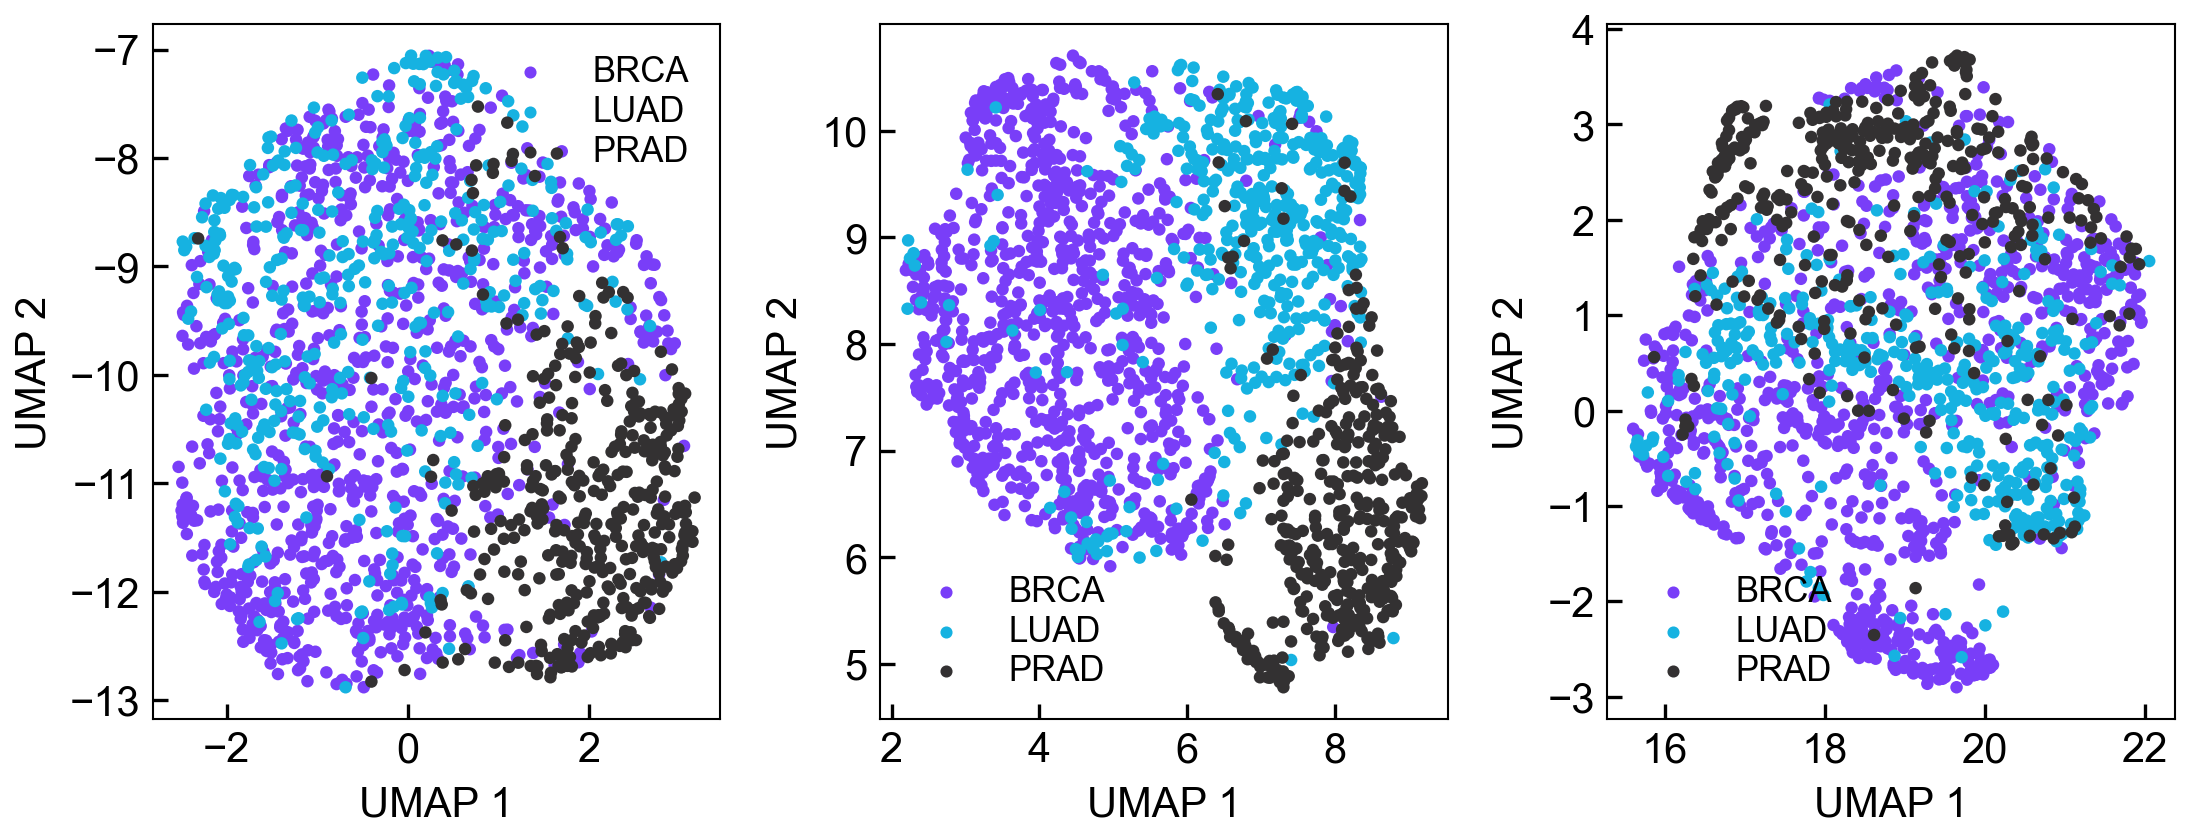

In [4]:
# assemble figure
fig, axs = plt.subplot_mosaic(
    """
    abc
    """,
    figsize=(7.5,3),
    dpi=300
)

ax = plot_proj_nuhifs(cancer_nuhif_data, ax=axs["a"], proj="umap")
ax = plot_proj_nuhifs(fibroblast_nuhif_data, ax=axs["b"], proj="umap")
ax = plot_proj_nuhifs(lymphocyte_nuhif_data, ax=axs["c"], proj="umap")
plt.tight_layout()
# plt.savefig("figures/result-1/raw.svg")

### Clustering:
1. Z-score all features from all slides.
2. Take median Z-score of feature for each cancer type.
3. Cluster each cell class separately.

In [5]:
def cluster_plot_hifs(cell_hif_data, cell_type):

    # nuHIF
    nuhifs_brca = cell_hif_data["brca"]
    nuhifs_luad = cell_hif_data["luad"]
    nuhifs_prad = cell_hif_data["prad"]

    # combine nuHIFs
    nuhifs_stack = pd.concat([nuhifs_brca, nuhifs_luad, nuhifs_prad], axis=0)
    identity = np.array(["BRCA"]*len(nuhifs_brca) + ["LUAD"]*len(nuhifs_luad) + ["PRAD"]*len(nuhifs_prad))
    nuhifs_z = (nuhifs_stack - nuhifs_stack.mean())/nuhifs_stack.std(ddof=0)
    nuhifs_z["subtype"] = identity

    # get medians for each
    nuhifs_zbrca = nuhifs_z[nuhifs_z["subtype"]=="BRCA"].drop(columns="subtype").median()
    nuhifs_zprad = nuhifs_z[nuhifs_z["subtype"]=="PRAD"].drop(columns="subtype").median()
    nuhifs_zluad = nuhifs_z[nuhifs_z["subtype"]=="LUAD"].drop(columns="subtype").median()

    nuhifs_zstack = pd.DataFrame([nuhifs_zbrca, nuhifs_zluad, nuhifs_zprad], index=["BRCA", "LUAD", "PRAD"]).T
    
    # clustering
    clust = clu.Cluster("nuHIF Median Z-Score")
    clust.attach_features_df(nuhifs_zstack)

    clust.perform_clustering(
        "by_hif",                  # cluster name
        cluster_by="rows",         # dimension we are clustering
        distance="euclidean",      # distance metric, see scipy.spatial.distance.pdist for options
        linkage="average",         # linkage type, see scipy.cluster.hierarchy.linkage for options
        threshold=0.00001,         # threshold value
        threshold_type="absolute", # threshold type ("absolute", "fractional")
        norm=None                  # robust z norm already applied before clustering
    )

    clust.perform_clustering(
        "by_csub",                 # cluster name
        cluster_by="cols",         # dimension we are clustering
        distance="euclidean",      # distance metric, see scipy.spatial.distance.pdist for options
        linkage="average",         # linkage type, see scipy.cluster.hierarchy.linkage for options
        threshold=40,              # threshold value
        threshold_type="absolute", # threshold type ("absolute", "fractional")
        norm=None                  # robust z norm already applied before clustering
    )
    
    # plot the clusters with a heatmap
    clumap_dict = vis.pathai_clustermap(
        clust,                                 # cluster object we are plotting
        row_cluster_name="by_hif",             # name of the cluster associated with row-wise clustering
        col_cluster_name=None,                 # (optional) name of the cluster associated with featurewise clustering
        norm_viz=None,                         # whether to norm the data for visualization (None, "z", "robust_z")
        cmap=dcolormap,                        # colormap
        show_xticks=False,                     # show x ticks -- if true prints column labels as the x-ticks
        vmin=-1.25,                            # value corresponding to colormap minimum
        vmax=1.25,                             # value corresponding to colormap maximum
        label_df=None,                         # (optional) dataframe with additional column data
        label_key=None,                        # (optional) column within label_df to display on left
        figsize=(3.5,4.4),                     # figure size
    )

    # the clustermap dictionary output contains infromation about the figure to enable further manipulation
    ax = clumap_dict["axes"][0]
    ax.set_xlabel("Feature Index")
    plt.tight_layout()
    # plt.savefig(f"figures/x0/raw_heatmap_{cell_type}.svg")
    
    for it in clumap_dict["row_cluster_names"]:
        print(it)

STD[FIBROBLAST_NUCLEUS_MEAN_LAB_CHANNEL_B]_H & E
STD[FIBROBLAST_NUCLEUS_SOLIDITY]_H & E
STD[FIBROBLAST_NUCLEUS_CIRCULARITY]_H & E
STD[FIBROBLAST_NUCLEUS_MAJOR_AXIS_LENGTH]_H & E
STD[FIBROBLAST_NUCLEUS_PERIMETER]_H & E
MEAN[FIBROBLAST_NUCLEUS_SOLIDITY]_H & E
MEAN[FIBROBLAST_NUCLEUS_MEAN_HSV_CHANNEL_SATURATION]_H & E
MEAN[FIBROBLAST_NUCLEUS_MEAN_LAB_CHANNEL_A]_H & E
MEAN[FIBROBLAST_NUCLEUS_CIRCULARITY]_H & E
STD[FIBROBLAST_NUCLEUS_ECCENTRICITY]_H & E
STD[FIBROBLAST_NUCLEUS_STD_LAB_CHANNEL_A]_H & E
MEAN[FIBROBLAST_NUCLEUS_STD_LAB_CHANNEL_A]_H & E
STD[FIBROBLAST_NUCLEUS_STD_LAB_CHANNEL_B]_H & E
STD[FIBROBLAST_NUCLEUS_STD_HSV_CHANNEL_SATURATION]_H & E
MEAN[FIBROBLAST_NUCLEUS_MEAN_LAB_CHANNEL_B]_H & E
STD[FIBROBLAST_NUCLEUS_MEAN_LAB_CHANNEL_A]_H & E
STD[FIBROBLAST_NUCLEUS_MEAN_GRAYSCALE_CHANNEL_GRAY]_H & E
MEAN[FIBROBLAST_NUCLEUS_MEAN_GRAYSCALE_CHANNEL_GRAY]_H & E
STD[FIBROBLAST_NUCLEUS_AREA]_H & E
MEAN[FIBROBLAST_NUCLEUS_STD_GRAYSCALE_CHANNEL_GRAY]_H & E
STD[FIBROBLAST_NUCLEUS_STD_GRAYSCALE

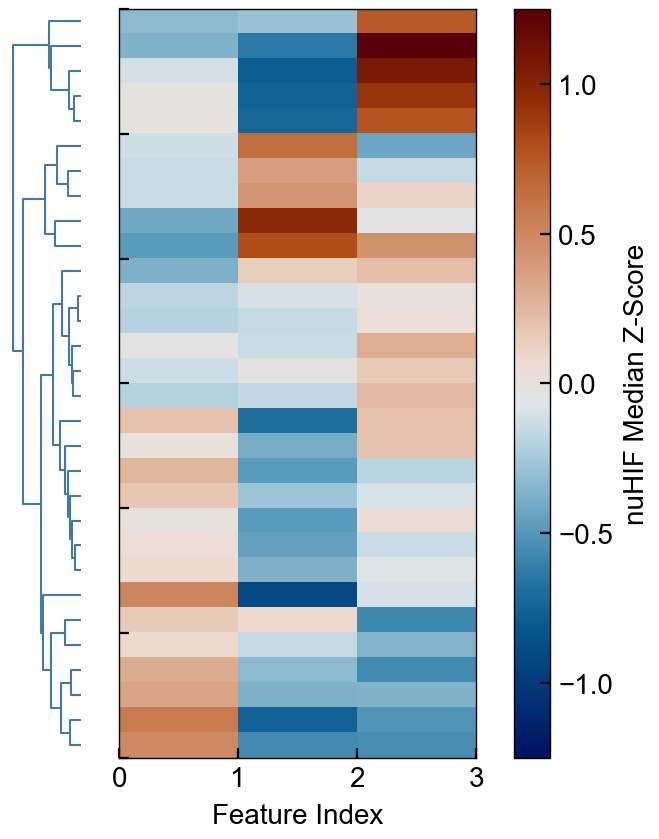

In [6]:
cluster_plot_hifs(fibroblast_nuhif_data, "Fibroblast")